<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>
Tree Model - Predictive Performance
</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Guido Grützner (<a href="mailto:guido.gruetzner@quantakt.com">guido.gruetzner@quantakt.com</a>)

# Introduction

A tree is fitted with hyperparameters established in "hptuning_tree.ipynb" and its performance evaluated.

# Initialisation

In [1]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss

from IPython.display import display
import matplotlib.pyplot as plt

# adjust according to your age and vision
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 15   # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick label font size 

import gltd_utilities

import time
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

* Adapt the path for the data file in the call of `load_gltd_data`, if necessary.
* Adapt pct to your requirements for anything between  $0.05\leq pct\leq1$. 
* Input 1 uses all data available, lower numbers the respective fraction. Below 0.05 predictions become somewhat volatile.

In [2]:
tic = time.time()
(X, Y, ID, nm_cat, nm_num, seed, rng) = gltd_utilities.load_gltd_data(
                                            "./", pct=0.3)
seed

'180354989235769554012206344561277505996'

# Evaluate

The whole procedure of repeated fits and subsequent analysis is wrapped into the following function. To assess overfitting and prediction uncertainty, we show train and test loss for a number of bootstrap iterations.

To enhance readability, log-loss is reported in bps (basis points), i.e. multiplied by 10'000 and rounded.  

In [3]:
ct = ColumnTransformer(
        [("", OneHotEncoder(drop="first", sparse_output=False, dtype=int),
                        nm_cat)], 
        remainder="passthrough", verbose_feature_names_out=False)

X_ohe = ct.fit_transform(X)

In [4]:
def fit_and_display():
    
    # the train-test splits to loop over, 
    # increase n_splits for more precise statistice 
    gss = GroupShuffleSplit(n_splits=6, train_size=0.7, test_size=0.3,
                            random_state=rng.integers(low=0, high=1000))
    
    # container for results
    lltrainlist = list()
    lltestlist = list()
    
    for ii, (trainidx, testidx) in enumerate(gss.split(X_ohe, groups=ID)):
        print("--------------------------------------------")
        print(f"Run {ii + 1}:")
        print("--------------------------------------------")
    
        xtrain, xtest = X_ohe[trainidx, :], X_ohe[testidx, :]
        ytrain, ytest = Y.iloc[trainidx], Y.iloc[testidx]
    
        md = DecisionTreeClassifier(
            random_state=rng.integers(low=0, high=1000),
            max_depth=7, 
            criterion="log_loss"
            )
        
        md.fit(xtrain, ytrain)
        
        # performance statistics
        phat = {
            "train": md.predict_proba(xtrain)[:,1], 
            "test": md.predict_proba(xtest)[:,1]}
        lltrainlist = (lltrainlist 
                       + [log_loss(ytrain, phat["train"])])
        lltestlist = (lltestlist 
                       + [log_loss(ytest, phat["test"])])
    
    # Analysis
    # remember: row-major!
    lltrainarr = ( 100**2 
                  * np.array(lltrainlist).reshape(gss.get_n_splits(), ))
    lltestarr = (100**2 
                  * np.array(lltestlist).reshape(gss.get_n_splits(), ))
    
    resdf = pd.DataFrame({"mean": [np.mean(lltrainarr), np.mean(lltestarr)],
                          "std": [np.std(lltrainarr), np.std(lltestarr)]},
                        index = ["train", "test"])
    tmpdf = resdf.select_dtypes(include=['number'])
    resdf[tmpdf.columns] = tmpdf.apply(lambda x: round(x,0)).astype("int")
    display(resdf.style.set_caption(f"Train and test loss on {gss.get_n_splits()} iterations"))
    
    fig, ax = plt.subplots(figsize = (12,9))
    pltdf = pd.DataFrame({"train": lltrainarr, "test": lltestarr})
    
    ax.boxplot(pltdf, tick_labels=pltdf.columns)
    ax.grid(which="major", axis="y")
    ax.set_ylabel("Loss in bps")
    ax.set_title("Bootstrapped loss")

##  Run model

--------------------------------------------
Run 1:
--------------------------------------------
--------------------------------------------
Run 2:
--------------------------------------------
--------------------------------------------
Run 3:
--------------------------------------------
--------------------------------------------
Run 4:
--------------------------------------------
--------------------------------------------
Run 5:
--------------------------------------------
--------------------------------------------
Run 6:
--------------------------------------------


,mean,std
train,533,2
test,548,7


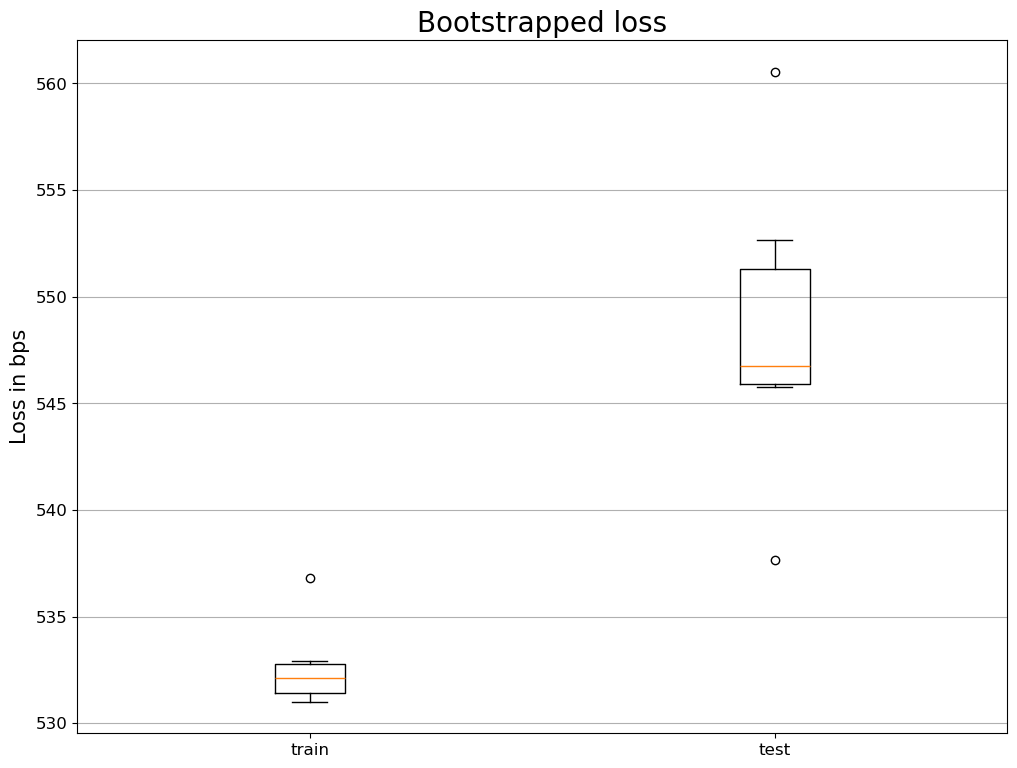

In [5]:
fit_and_display()

The model overfits somewhat with `pct=0.3`. The reader can easily verify using `pct=1` that train/test are more balanced with larger amounts of data. 

In [6]:
print(f"Time it took: {np.ceil((time.time() - tic)/60)}min.")

Time it took: 4.0min.
